In [1]:
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
### Declaring global constants:
All = slice(None)

In [2]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel():
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source    
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [3]:
### DEFINING EXTRACTION MARKET CAPITALIZATION DATA FROM GENERAL MS EXCEL SOURCE
def get_mcaps_from_excel(str_sheet_name):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd    
    ### Constants declaring:
    path_msci_data = 'Data_Files/Source_Files/MSCI_mcaps.xlsx'
    arr_rows_to_skip = np.arange(0, 28)
    ### Extracting market caps data:
    df_mcap = pd.read_excel(io = path_msci_data, sheet_name = str_sheet_name, skiprows = arr_rows_to_skip, header = 0, index_col = 0,
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False) 
    ### Stacking index data:
    ser_mcap = df_mcap.stack(dropna = False)
    ser_mcap.index.names = ['Date', 'Country']
    df_mcap = ser_mcap.reset_index(level = 'Country')
    ser_mcap = df_mcap.set_index('Country', append = True).squeeze()
    ser_mcap = ser_mcap.sort_index(level = ['Country', 'Date'])
    ser_mcap.name = 'Market_Cap'
    
    return ser_mcap

In [ ]:
## DEFINING EXTRACTION CURRENCY EXCHANGE DATA FROM GENERAL MS EXCEL SOURCE
def get_fx_from_excel(str_sheet_name):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd    
    ### Constants declaring:
    path_msci_data = 'Data_Files/Source_Files/MSCI_FX.xlsx'
    arr_rows_to_skip = np.arange(0, 28)
    num_rows_for_quote = 16
    num_country_ID_for_qoute = 9
    num_factor_for_quote = 15
    ### Extracting currency exchange rates data:
    df_fx = pd.read_excel(io = path_msci_data, sheet_name = str_sheet_name, skiprows = arr_rows_to_skip, header = 0, index_col = 0,
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
    ### Extracting quote factors
    df_quote_factor = pd.read_excel(io = path_msci_data, sheet_name = str_sheet_name, nrows = num_rows_for_quote,
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
    ser_factor = pd.Series(df_quote_factor.iloc[num_factor_for_quote].values[1:], index = df_quote_factor.iloc[num_country_ID_for_qoute].values[1:])
    ser_factor.fillna(1, inplace = True)
    ser_factor.name = 'Quote_Factor'
    ### Stacking index data:
    ser_fx = df_fx.stack(dropna = False)
    ser_fx.index.names = ['Date', 'Country']
    df_fx = ser_fx.reset_index(level = 'Country')
    ser_fx = df_fx.set_index('Country', append = True).squeeze()
    ser_fx = ser_fx.sort_index(level = ['Country', 'Date'])
    ser_fx.name = 'FX'
    ### Applying quote factors:   
    df_fx = ser_fx.to_frame().join(ser_factor, on = 'Country', how = 'left')
    ser_fx = df_fx['FX'] / df_fx['Quote_Factor']

    return ser_fx

In [5]:
### MARKET CAP MIXED CASTING TO USD AND FILLING THE GAPS:
### Constants declaring:
str_sheet_mc_USD = 'Market Cap USD'
str_sheet_mc_mixed = 'Market Cap MIXED'
str_sheet_fx = 'FX Rates LOCUSD'
### Market caps data reading:
ser_mcap_USD = get_mcaps_from_excel(str_sheet_mc_USD)
ser_mcap_mixed = get_mcaps_from_excel(str_sheet_mc_mixed)
### FX data reading and filling currency exchange coefficients for USD-nominated countries with 1:
ser_fx = get_fx_from_excel(str_sheet_fx)
arr_fx_USD_countries = list(ser_fx.groupby('Country').filter(lambda iter_group: iter_group.count() == 0).index.get_level_values(1).unique())
ser_fx.loc[ser_fx.groupby('Country').filter(lambda iter_group: iter_group.count() == 0).index] = 1
### Multiplying market caps to get USD-nominated values:
ser_mcap_fx = ser_mcap_mixed.mul(ser_fx)
ser_mcap_fx.name = 'Market Cap'
### Receiving MSCI membership data:    
ser_market_membership = get_market_membership_from_excel()
### Adding market membership:
df_mcap_fx = ser_mcap_fx.to_frame().join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
ser_mcap = df_mcap_fx.set_index('Market', drop = True, append = True).sort_index(level = ['Country', 'Date']).squeeze()
### Filling values for all-empty countries (only in ISON universe):
arr_empty_countries = ser_mcap.groupby('Country').filter(lambda iter_group: iter_group.count() == 0).index.get_level_values(1).unique()
ser_mcap.loc[All, arr_empty_countries, All] = \
ser_mcap.groupby(['Date', 'Market']).apply(lambda iter_group: iter_group.fillna(iter_group.mean())).loc[All, arr_empty_countries, All]
ser_mcap = round(ser_mcap, 2)
### Back-filling backward from firsl valid value:
ser_mcap_bfill = ser_mcap.groupby(['Country']).apply(lambda iter_group: \
                                                     iter_group.iloc[: iter_group.index.get_loc(iter_group.first_valid_index()) + 1].bfill()).droplevel(0)
ser_mcap = ser_mcap.combine_first(ser_mcap_bfill).sort_index(level = ['Country', 'Date'])
### Forward-filling all gaps:
ser_mcap = ser_mcap.groupby(['Country']).ffill()

In [6]:
### MARKET CAPITALIZATIONS SAVING
path_market_cap = 'Data_Files/Source_Files/Market_Cap.h5'
key_market_cap = 'mcap'
ser_mcap.to_hdf(path_market_cap, key_market_cap, mode = 'w', format = 'fixed')

In [7]:
### MARKET CAPS EXPORT RESULTS
### Generating tables for visual control:
ser_mcap_USD_country = ser_mcap_USD.groupby('Country').count()
ser_mcap_mixed_country = ser_mcap_mixed.groupby('Country').count()
ser_fx_country = ser_fx.groupby('Country').count()
ser_mcap_fx_country = ser_mcap_fx.groupby('Country').count()
df_mcap_compare = pd.concat([ser_mcap_USD, ser_mcap_mixed, ser_mcap_fx], keys = ['USD', 'Mixed', 'FX_Casted'], axis = 1)
df_mcap_compare['Deviation'] = ((df_mcap_compare['FX_Casted'] - df_mcap_compare['USD']) / df_mcap_compare['USD']).abs()
df_mcap_compare_top = df_mcap_compare.dropna().groupby('Country').last().sort_values(['Deviation'], ascending = False)
### Results printing:
print('All about USD Market Cap data:'.upper())
print('Not NaN values number:', ser_mcap_USD.count())
print('Nominal countries number:', ser_mcap_USD_country.count())
print('Countries with only NaN values:', ser_mcap_USD_country[ser_mcap_USD_country == 0].count(), ':', list(ser_mcap_USD_country[ser_mcap_USD_country == 0].index))

print('All about mixed Market Cap data:'.upper())
print('Not NaN values number:', ser_mcap_mixed.count())
print('Nominal countries number:', ser_mcap_mixed_country.count())
print('Countries with only NaN values:', ser_mcap_mixed_country[ser_mcap_mixed_country == 0].count(), ':', list(ser_mcap_mixed_country[ser_mcap_mixed_country == 0].index))

print('All about currency exchange data:'.upper())
print('Not NaN values number:', ser_fx.count())
print('Nominal countries number:', ser_fx_country.count())
print('USD-nominated countries:', len(arr_fx_USD_countries), ':', arr_fx_USD_countries)

print('All about mixed Market Cap casted to USD data by FX:'.upper())
print('Not NaN values number:', ser_mcap_fx.count())
print('Nominal countries number:', ser_mcap_fx_country.count())
print('Countries with only NaN values:', ser_mcap_fx_country[ser_mcap_fx_country == 0].count(), ':', list(ser_mcap_fx_country[ser_mcap_fx_country == 0].index))

print('Sources comparision:'.upper())
print('USD Not NaN and FX NaN count:', len(df_mcap_compare.loc[(df_mcap_compare['USD'].notna() & df_mcap_compare['FX_Casted'].isna())].index))
print('USD NaN and FX Not NaN count:', len(df_mcap_compare.loc[(df_mcap_compare['USD'].isna() & df_mcap_compare['FX_Casted'].notna())].index))
print('Non-negligible deviations between nominal USD Market Caps and Mixed Market Caps casted to USD by FX rate for last date values:\n', 
      df_mcap_compare_top.loc[df_mcap_compare_top['Deviation'] > 0.01])

ALL ABOUT USD MARKET CAP DATA:
Not NaN values number: 6825
Nominal countries number: 84
Countries with only NaN values: 8 : ['CI', 'CR', 'EC', 'MT', 'PA', 'SA', 'UG', 'ZM']
ALL ABOUT MIXED MARKET CAP DATA:
Not NaN values number: 18594
Nominal countries number: 84
Countries with only NaN values: 4 : ['CR', 'EC', 'UG', 'ZM']
ALL ABOUT CURRENCY EXCHANGE DATA:
Not NaN values number: 24424
Nominal countries number: 84
USD-nominated countries: 14 : ['AR', 'BR', 'CI', 'CL', 'CO', 'EC', 'IL', 'KZ', 'MX', 'PE', 'QA', 'RU', 'US', 'ZM']
ALL ABOUT MIXED MARKET CAP CASTED TO USD DATA BY FX:
Not NaN values number: 18380
Nominal countries number: 84
Countries with only NaN values: 4 : ['CR', 'EC', 'UG', 'ZM']
SOURCES COMPARISION:
USD Not NaN and FX NaN count: 0
USD NaN and FX Not NaN count: 11555
Non-negligible deviations between nominal USD Market Caps and Mixed Market Caps casted to USD by FX rate for last date values:
                  USD      Mixed    FX_Casted  Deviation
Country                

In [8]:
### DEFINING EXTRACTION RETURNS DATA FROM GENERAL MS EXCEL SOURCE
def get_msci_returns_from_excel(str_sheet_name):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd    
    ### Constants declaring:
    path_msci_data = 'Data_Files/Source_Files/MSCI_Returns.xlsx'     
    arr_rows_to_skip = np.arange(0, 27)    
    ### Extracting returns data:
    df_index_return = pd.read_excel(io = path_msci_data, sheet_name = str_sheet_name, skiprows = arr_rows_to_skip, header = 0, index_col = 0,
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False) 
    ### Stacking index data:
    ser_index_return = df_index_return.stack(dropna = False).to_frame()
    ser_index_return.index.names = ['Date', 'Country']
    df_index_return = ser_index_return.reset_index(level = 'Country')
    ser_index_return = df_index_return.set_index('Country', append = True).squeeze()
    ser_index_return = ser_index_return.sort_index(level = ['Country', 'Date'])
    ser_index_return.name = 'Total_Return'
    ### Filling the gaps:
    ser_index_return = ser_index_return.groupby('Country').fillna(method = 'ffill')
    ### Extracting return from index:
    ser_index_return_shifted = ser_index_return.groupby('Country').shift()
    ser_return = ser_index_return.div(ser_index_return_shifted) - 1
    ### Reindexing to confirm business-end-of-month indexation:
    df_return = ser_return.reset_index()
    df_return.loc[All, 'Date'] = df_return.loc[All, 'Date'] - pd.offsets.MonthBegin() + pd.offsets.BMonthEnd()
    ser_return = df_return.set_index(['Date', 'Country']).squeeze()
    
    return ser_return

In [9]:
### DEFINING SHEETS PRIORITY FOR RETURNS EXTRACTING

### Sheets lists from From prior to minor:
arr_sheet_LOC = ['Returns LOC', 'Returns LOC - Old MSCI Code', 'Returns LOC - Main Index']
arr_sheet_USD = ['Returns USD', 'Returns USD - Old MSCI Code', 'Returns USD - Main Index']
### Extracting and combining USD returns:
for iter_number, iter_sheet in enumerate(arr_sheet_USD):
    if (iter_number == 0):
        ### Extracting prior data:
        ser_return_USD = get_msci_returns_from_excel(iter_sheet)
    else:
        ### Filling the gaps in prior data:
        ser_return_USD = ser_return_USD.combine_first(get_msci_returns_from_excel(iter_sheet))
### Extracting and combining LOC returns:        
for iter_number, iter_sheet in enumerate(arr_sheet_LOC):
    if (iter_number == 0):
        ### Extracting prior data:
        ser_return_LOC = get_msci_returns_from_excel(iter_sheet)
    else:
        ### Filling the gaps in prior data:
        ser_return_LOC = ser_return_LOC.combine_first(get_msci_returns_from_excel(iter_sheet))
### Filling the gaps in USD returns with LOC ones:
ser_return_common = ser_return_USD.combine_first(ser_return_LOC).sort_index(level = ['Country', 'Date'])
### Receiving MSCI membership data:    
ser_market_membership = get_market_membership_from_excel()
### Adding market membership:
df_return_common = ser_return_common.to_frame().join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
ser_return = df_return_common.set_index('Market', drop = True, append = True).sort_index(level = ['Country', 'Date']).squeeze()
ser_return.name = 'Return'
#ser_return.to_excel('Data_Files/Test_Files/Test_Returns_Combined.xlsx')

In [10]:
### INTEGRATED RETURNS SAVING
path_return = 'Data_Files/Source_Files/Returns_Integrated.h5'
key_return = 'returns'
ser_return.to_hdf(path_return, key_return, mode = 'w', format = 'fixed')

In [11]:
###########################################################################################################################################################################

In [1]:
### EVENT STUDY INITIALISING
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
### Declaring global constants:
All = slice(None)

In [2]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel():
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source    
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [3]:
### LOADING DATA FOR EVENT STUDY
### Loading ISON Universe:
ser_market_membership = get_market_membership_from_excel()
### Credit debt collapsed ranking loading:
path_collapsed_marked = 'Data_Files/Source_Files/Collapsed_Rank_Marked.h5'
key_collapsed = 'Rank'
ser_ranking = pd.read_hdf(path_collapsed_marked, key_collapsed)
ser_ranking = ser_ranking.loc[All, All, ser_market_membership.index.get_level_values(1).unique().to_list()]
### Market Caps loading:
path_market_cap = 'Data_Files/Source_Files/Market_Cap.h5'
key_market_cap = 'mcap'
ser_mcap = pd.read_hdf(path_market_cap, key_market_cap)
### Returns loading:
path_return = 'Data_Files/Source_Files/Returns_Integrated.h5'
key_return = 'returns'
ser_return = pd.read_hdf(path_return, key_return)
ser_return = ser_return.loc[All, ser_market_membership.index.get_level_values(1).unique().to_list(), All]

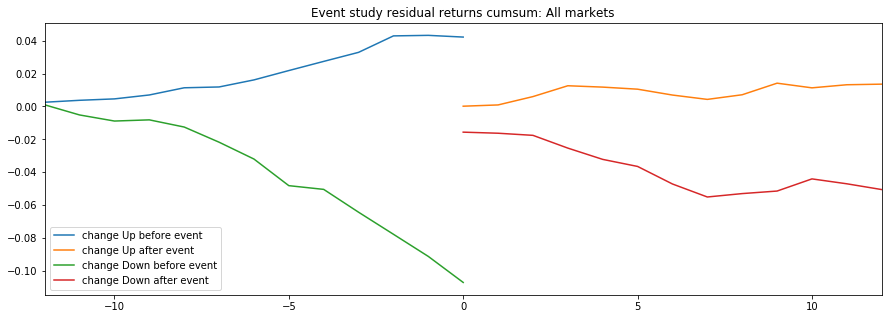

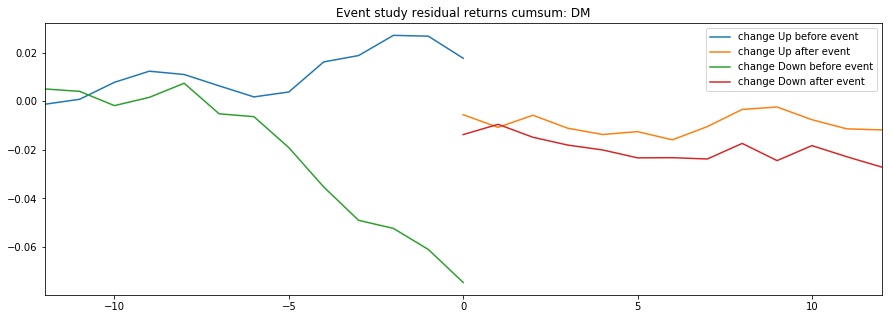

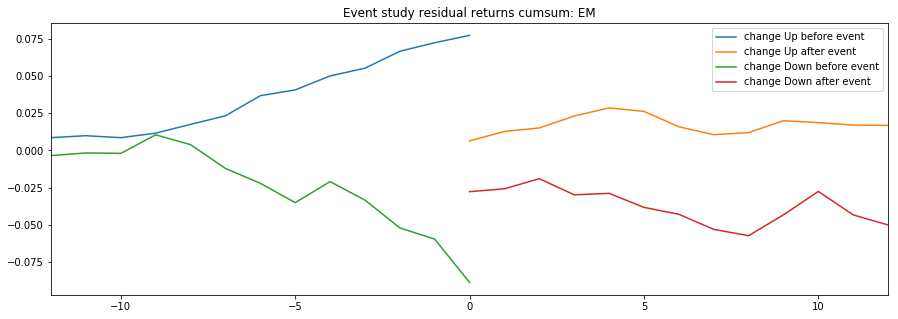

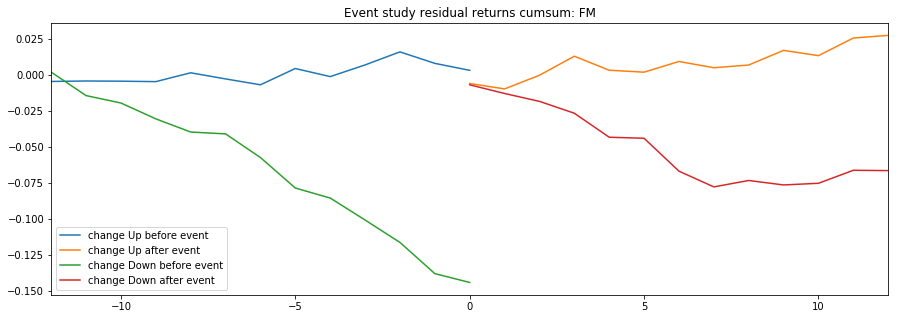

In [29]:
### PREPARING FOR EVENT STUDY
### Ranking changes calculation:
ser_ranking_diff = ser_ranking.groupby('Country').diff()
ser_ranking_diff.name = 'Rank Delta'
ser_ranking_sign = ser_ranking_diff.loc[(ser_ranking_diff != 0) & ser_ranking_diff.notna()] = ser_ranking_diff / ser_ranking_diff.abs()
ser_ranking_sign.name = 'Change Sign'
#pd.concat([ser_ranking, ser_ranking_diff], axis = 1).to_excel('Data_Files/Test_Files/Test_Event_Study.xlsx')
### Highlighting change markers:
df_ranking_marker = pd.concat([ser_ranking, ser_ranking_sign, ser_ranking_diff], axis = 1)
df_ranking_marker = df_ranking_marker.reorder_levels(['Date', 'Country', 'Market'], axis = 0)
ser_return_marker = df_ranking_marker.join(ser_return).set_index(['Rank', 'Change Sign', 'Rank Delta'], append = True).squeeze()
### Constants declaring:
num_period = 24
num_min_countries = 4
### Constants for universe filtering:
arr_market_index = [['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]
arr_market_name = ['All markets', 'DM', 'EM', 'FM']
### Markets looping: 
for iter_market_num, iter_market_index in enumerate(arr_market_index):
    ### Events dictionary declaring:
    dict_ser_events = {}
    dict_ser_events['up'] = ser_return_marker.loc[All, All, iter_market_index, All, 1, All].dropna()
    dict_ser_events['down'] = ser_return_marker.loc[All, All, iter_market_index, All, -1, All].dropna()
    ### Result dictionary declaring:
    dict_ser_result = {}
    ### Performing main loop:
    for iter_key in dict_ser_events:
        ### Before and after arrays declaring:
        dict_ser_result[iter_key] = {}
        arr_iter_before = []
        arr_iter_after = []    
        ser_iter_event = dict_ser_events[iter_key]
        for iter_counter, iter_index in enumerate(ser_iter_event.index):
            iter_date = iter_index[0]
            iter_country = iter_index[1]
            iter_market = iter_index[2]
            iter_rank = iter_index[3]
            iter_delta = iter_index[4]
            ser_iter_country_return_before = ser_return_marker.loc[All, iter_country, All, All, All, All]
            ser_iter_country_return_before = ser_iter_country_return_before.loc[iter_date - pd.offsets.BMonthEnd(num_period) : iter_date, All]
            ser_iter_country_return_before.reset_index(['Market', 'Rank', 'Change Sign', 'Rank Delta'], drop = True, inplace = True)
            ser_iter_country_return_after = ser_return_marker.loc[All, iter_country, All, All, All, All]
            ser_iter_country_return_after = ser_iter_country_return_after.loc[iter_date : iter_date + pd.offsets.BMonthEnd(num_period), All]
            ser_iter_country_return_after.reset_index(['Market', 'Rank', 'Change Sign', 'Rank Delta'], drop = True, inplace = True)        
            ### Basis countries searching:
            ser_iter_basis_countries = ser_return_marker.loc[iter_date, All, iter_market, All, All, 0].sort_index(level = 'Rank').reset_index('Country')
            ### Before change countries:
            iter_shift = 0
            iter_flag = True
            while iter_flag:
                if (ser_iter_basis_countries.loc[iter_rank - iter_shift : iter_rank + iter_shift]['Return'].count() >= num_min_countries):
                    arr_iter_countries_before = list((ser_iter_basis_countries.loc[iter_rank - iter_shift : iter_rank + iter_shift]['Country']))
                    iter_flag = False
                iter_shift = iter_shift + 1
            ### After change countries:            
            iter_shift = 0
            iter_flag = True
            while iter_flag:
                if (ser_iter_basis_countries.loc[iter_rank + iter_delta - iter_shift : iter_rank + iter_delta + iter_shift]['Return'].count() >= num_min_countries):
                    arr_iter_countries_after = list((ser_iter_basis_countries.loc[iter_rank + iter_delta - iter_shift : iter_rank + iter_delta + iter_shift]['Country']))
                    iter_flag = False
                iter_shift = iter_shift + 1         
            ### Mean basis vectors for returns creating:
            ser_iter_basis_return_before = ser_return_marker.loc[All, arr_iter_countries_before, All, All, All, All].sort_index(level = 'Date')
            ser_iter_basis_return_before = ser_iter_basis_return_before.loc[iter_date - pd.offsets.BMonthEnd(num_period) : iter_date, All]
            ser_iter_basis_return_before = ser_iter_basis_return_before.groupby('Date').mean()      
            ser_iter_basis_return_after = ser_return_marker.loc[All, arr_iter_countries_after, All, All, All, All].sort_index(level = 'Date')
            ser_iter_basis_return_after = ser_iter_basis_return_after.loc[iter_date : iter_date + pd.offsets.BMonthEnd(num_period), All]
            ser_iter_basis_return_after = ser_iter_basis_return_after.groupby('Date').mean()  
            ### Calculating residual returns and untieing from dates:
            ser_iter_residual_before = (ser_iter_country_return_before - ser_iter_basis_return_before).reset_index(drop = True)
            ser_iter_residual_before.index = ser_iter_residual_before.index - num_period
            ser_iter_residual_after = (ser_iter_country_return_after - ser_iter_basis_return_after).reset_index(drop = True)
            ### Collecting results to arrays:
            arr_iter_before.append(ser_iter_residual_before)
            arr_iter_after.append(ser_iter_residual_after)        
    #        if (iter_counter > 1):
    #            break   

        ### Results aggregating:
        ser_agg_before = pd.concat(arr_iter_before, axis = 0)
        ser_agg_after = pd.concat(arr_iter_after, axis = 0)
        dict_ser_result[iter_key]['before'] = ser_agg_before.groupby(ser_agg_before.index).mean()
        dict_ser_result[iter_key]['after'] = ser_agg_after.groupby(ser_agg_after.index).mean()        
#        break        
    ### Results visualizing:
    (dict_ser_result['up']['before']).cumsum().plot(figsize = (15, 5), label = 'change Up before event')
    (dict_ser_result['up']['after']).cumsum().plot(figsize = (15, 5), label = 'change Up after event')    
    (dict_ser_result['down']['before']).cumsum().plot(figsize = (15, 5), label = 'change Down before event')
    (dict_ser_result['down']['after']).cumsum().plot(figsize = (15, 5), label = 'change Down after event')   
    ### Results showing:
    plt.legend()    
    plt.title('Event study residual returns cumsum: ' + arr_market_name[iter_market_num])    
    plt.show()

In [5]:
###########################################################################################################################################################################

In [1]:
### EFFICACY MEASURES INITIALISING
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd  
### Declaring global constants:
All = slice(None)

In [2]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel():
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source    
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    All = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[All, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [3]:
### DEFINING SIMPLE WEIGHTED AVERAGE:
def get_weighted_average(ser_to_manage, ser_weights):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd            
    ### Clearing and docking vectors:
    ser_to_manage_filtered = ser_to_manage.dropna()
    ser_weights_filtered = ser_weights.dropna()
    index_filtered = ser_to_manage_filtered.index.intersection(ser_weights_filtered.index)
    ser_to_manage_filtered = ser_to_manage_filtered[index_filtered]
    ser_weights_filtered = ser_weights_filtered[index_filtered]
    ### Result calculating:
    if (ser_to_manage_filtered.count() > 0):
        num_result = ser_to_manage_filtered.dot(ser_weights_filtered) / sum(ser_weights_filtered)
    else:
        num_result = np.NaN
    
    return num_result    

In [4]:
### DEFINING STANDARTIZATION FUNCTION
def get_weighted_standartized_z_score(ser_to_manage, ser_weights, arr_truncates, reuse_outliers = False, center_result = True, extended_output = False):
    ### Importing standard modules and date-special modules
    import numpy as np
    import pandas as pd    
    ### Declaring local constants & variables:
    arr_mean = []
    arr_std = []
    ### Workhorse and resulting data vectors initialising:
    ser_iter_data = ser_to_manage.dropna()
    ser_iter_weights = ser_weights.dropna()
    ser_result = pd.Series(np.NaN, index = ser_to_manage.index)
    ### Checking for not NaN initial intersection:
    if (len(ser_iter_data.index.intersection(ser_iter_weights.index)) > 0):
        ### Looping by boundaries array:
        for iter_bound in arr_truncates:        
            ### Clearing and docking vectors:        
            index_iter = ser_iter_data.index.intersection(ser_iter_weights.index)
            ser_iter_data = ser_iter_data[index_iter]
            ser_iter_weights = ser_iter_weights[index_iter]         
            ### Properties calculating and saving:
            num_mean_iter = get_weighted_average(ser_iter_data, ser_iter_weights)
            num_std_iter = ser_iter_data.std()
            arr_mean.append(num_mean_iter)
            arr_std.append(num_std_iter)
            ser_iter_data = (ser_iter_data - num_mean_iter) / num_std_iter          
            ### Standartizing:
            ser_iter_data.loc[ser_iter_data.abs() >= iter_bound] = np.sign(ser_iter_data) * iter_bound 
            if not (reuse_outliers):
                ### Saving to result and excluding from further calculations truncated values:     
                ser_result.where(ser_iter_data.abs() < iter_bound, np.sign(ser_iter_data) * iter_bound, inplace = True)
                ser_iter_data = ser_iter_data[ser_iter_data.abs() < iter_bound]           
        ### Aggregating result:
        ser_result[ser_iter_data.index] = ser_iter_data
        ### Centering result if need to:
        if (center_result):      
            ser_result = ser_result - get_weighted_average(ser_result, ser_weights) 
    ### Results exporting:
    if (extended_output):
        return [ser_result, arr_mean, arr_std]
    else:
        return ser_result

In [5]:
### DEFINING FACTORS STANDARTIZATION
def get_standartized_factor(ser_factor, ser_weights = pd.Series(np.NaN), arr_market_filter = ['DM', 'EM', 'FM'], score_grouping = 'within',
                            score_boundaries = [2.5, 2.0], score_reuse_outliers = False, score_center_result = True):    
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    All = slice(None)
    ### Market filtering:
    ser_factor = ser_factor.copy().loc[All, All, arr_market_filter]
    ### Weights tuning:
    if (ser_weights.count() == 0):
        ser_weights = pd.Series(1, index = ser_factor.index)
    ser_weights.name = 'Weight'
    ### Joining factor and weights:
    df_scoring = pd.merge(ser_factor, ser_weights, how = 'left', left_index = True, right_index = True)
    df_scoring.columns = ['Factor', 'Weight']
    ### Performing common scoring:
    if (score_grouping == 'full'):
        ser_result = df_scoring.groupby('Date').apply(lambda iter_group: \
                        get_weighted_standartized_z_score(iter_group['Factor'], iter_group['Weight'], 
                                                          score_boundaries, score_reuse_outliers, score_center_result)).reset_index(0, drop = True).squeeze()
    if (score_grouping == 'within'):
        ser_result = df_scoring.groupby(['Date', 'Market']).apply(lambda iter_group: \
                        get_weighted_standartized_z_score(iter_group['Factor'], iter_group['Weight'], 
                                                          score_boundaries, score_reuse_outliers, score_center_result)).reset_index([0, 1], drop = True).squeeze()        
    ser_result.name = ser_factor.name
    ### Results exporting:
    return ser_result

In [6]:
### DEFINING EFFICACY MEASURES
def get_efficacy_measures(ser_factor, ser_return, ser_weights, arr_measures, return_shift = 0):
    ### Importing standard modules and data-special modules:
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    from scipy import stats as ss
    ### Declaring local constants & variables:
    All = slice(None)
    dict_measure = {}
    ### Defining get_measure group level function:
    def get_measure(df_to_measure, iter_measure):
        ### Checking data sufficiency:
        if (len(df_to_measure.dropna().index) > 1):
            arr_factor = df_to_measure.dropna()['Factor'].values
            arr_factor_added = sm.add_constant(arr_factor)
            arr_return = df_to_measure.dropna()['Return'].values
            arr_weights = df_to_measure.dropna()['Weight'].values
            ### Measure calculating:
            if (iter_measure == 'ic_spearman'):
                ### Spearmen information coefficient:
                num_result = ss.spearmanr(arr_factor, arr_return).correlation
            if (iter_measure == 'ic_pearson'):
                ### Pearson information coefficient:
                num_result = ss.pearsonr(arr_factor, arr_return)[0]
            if (iter_measure == 'fmb_eqw'):
                ### Fama-McBeth cross-sectional regression beta coefficient (equal weighted residuals):
                wls_model = sm.OLS(arr_return, arr_factor_added)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]
            if (iter_measure == 'fmb_mcap'):
                ### Fama-McBeth cross-sectional regression beta coefficient (market capitalization weighted residuals):
                wls_model = sm.WLS(arr_return, arr_factor_added, weights = arr_weights)
                wls_results = wls_model.fit()
                num_result = wls_results.params[0]
        else:
            num_result = np.NaN
        ### Preparing results:
        return num_result
    ### Preparing shifted returns:
    ser_return_shifted = ser_return.groupby('Country').shift(-return_shift)
    ### Preparing combined vectors for measures calculating:
    if (ser_weights.count() == 0):
        ser_weights = pd.Series(1, index = ser_factor.index)
    df_to_measure = pd.concat([ser_factor, ser_return_shifted, ser_weights], axis = 1)
    df_to_measure.columns = ['Factor', 'Return', 'Weight']
    ### Looping efficacy measures for calculating measures timeseries:
    for iter_measure in arr_measures:
        dict_measure[iter_measure] = df_to_measure.groupby('Date').apply(get_measure, iter_measure = iter_measure)
    ### Preparing results:
    return pd.concat(dict_measure, axis = 1)

In [7]:
def get_measure_stats(df_measures):
    ### Importing standard modules and data-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables:
    dict_stats = {}
    ### Stats calculating:
    for iter_measure in df_measures.columns:
        ser_iter_measure = pd.Series()
        ser_iter_measure['count'] = df_measures[iter_measure].count()
        ser_iter_measure['min'] = df_measures[iter_measure].min()
        ser_iter_measure['max'] = df_measures[iter_measure].max()        
        ser_iter_measure['mean'] = df_measures[iter_measure].mean()
        ser_iter_measure['std'] = df_measures[iter_measure].std()
        ser_iter_measure['median'] = df_measures[iter_measure].median()        
        ser_iter_measure['perc_25'] = df_measures[iter_measure].quantile(0.25)
        ser_iter_measure['perc_75'] = df_measures[iter_measure].quantile(0.75)
        ser_iter_measure['iq_range'] = df_measures[iter_measure].quantile(0.75) - df_measures[iter_measure].quantile(0.25)
        ser_iter_measure['mean_abs'] = df_measures[iter_measure].abs().mean()
        ser_iter_measure['t_stat'] = (df_measures[iter_measure].mean() / df_measures[iter_measure].std()) * np.sqrt(df_measures[iter_measure].count())  
        dict_stats[iter_measure] = ser_iter_measure
    ### Preparing results:
    return pd.concat(dict_stats, axis = 1)

In [8]:
### LOADING DATA FOR EFFICACY MEASURES CALCULATING
### Loading ISON Universe:
ser_market_membership = get_market_membership_from_excel()
### Credit debt collapsed ranking loading:
path_collapsed_marked = 'Data_Files/Source_Files/Collapsed_Rank_Marked.h5'
key_collapsed = 'Rank'
ser_ranking = pd.read_hdf(path_collapsed_marked, key_collapsed)
ser_ranking = ser_ranking.loc[All, All, ser_market_membership.index.get_level_values(1).unique().to_list()].reorder_levels([0, 2, 1])
### Market Caps loading:
path_market_cap = 'Data_Files/Source_Files/Market_Cap.h5'
key_market_cap = 'mcap'
ser_mcap = pd.read_hdf(path_market_cap, key_market_cap)
### Returns loading:
path_return = 'Data_Files/Source_Files/Returns_Integrated.h5'
key_return = 'returns'
ser_return = pd.read_hdf(path_return, key_return)
ser_return = ser_return.loc[All, ser_market_membership.index.get_level_values(1).unique().to_list(), All]

In [9]:
### TESTER
ser_ranking_z = get_standartized_factor(ser_ranking, ser_mcap, ['DM', 'EM', 'FM'], 'within', [2.5, 2.0], False, False)
df_ranking_z_measures = get_efficacy_measures(ser_ranking_z, ser_return, ser_mcap, ['ic_spearman', 'ic_pearson', 'fmb_eqw', 'fmb_mcap'])
get_measure_stats(df_ranking_z_measures)

,ic_spearman,ic_pearson,fmb_eqw,fmb_mcap
count,308.000000,308.000000,308.000000,308.000000
min,-0.465888,-0.451062,-0.242133,-0.193545
max,0.632485,0.617659,0.142294,0.119339
mean,-0.005331,-0.014519,0.008594,0.007868
std,0.166749,0.172414,0.045261,0.042618
median,-0.009238,-0.025428,0.011153,0.012836
perc_25,-0.120271,-0.129652,-0.014012,-0.015772
perc_75,0.100423,0.109176,0.035888,0.032069
iq_range,0.220694,0.238828,0.049901,0.047841
mean_abs,0.131308,0.137136,0.034129,0.033319
